
![](./assets/bigquery.png)

# Statistics 147 Final

**By: Jason Lim**

Winter 2023

## Data Warehouses

> A data warehouse is an enterprise system used for the analysis and reporting of structured and semi-structured data from multiple sources [...] designed to give a long-range view of data over time, making it a primary component of business intelligence (1).

- Production databases are optimized for small, real-time transactions, not large analytical queries. 
- Production databases are constantly changing and may be messy.

### Cloud Data Warehouse
- Flexible and scalable with low overhead
- Tends to be faster. Size and scale of data centers hard to replicate.
- Seamlessly connects to other cloud services
- In the case of Google, easy to try ML and AI tools without leaving cloud (3)

## Google BigQuery

### History
As Google's data scaled, needed a tool to run fast SQL queries on massive datasets. Google invented Dremel, which it used internally for years. Dremel had "unbelievable performance" and was used extensively at Google.

BigQuery was released in 2012 as public version of Dremel. Expanded to hosted, managed cloud-based structured storage provider (2).

### Architecture
- Uses slightly nonstandard flavor of SQL
- Dremel parallelized SQL queries and scales horizontally. Not MapReduce (even faster)
- Stores data across many parallel disks for faster reads. Columnar format.
- Roughly ~50GB/sec. 95% of all queries on public clusters finish in <5 seconds

## Using Google BigQuery

- Cloud Console
  - Full GUI
- Command line tool
  - gcloud CLI 
  - Locally or in the cloud
  - Good for headless setup
- Client libraries
  - C#, Go, Java, Node.js, PHP, Python, Ruby
  - Best programmatic access

## Cloud Console: Adding Data

<center><img src="./assets/gbq-load-file.png" width=400px/></center>

**Note**: Table size is limited to <10GB. Upload is even more constrained (can use Google Cloud Object Storage, or Drive for smaller objects)

## Cloud Console: Writing Queries

<img src="./assets/gbq-cloud-queries.png"/>

- Convenient workspace for writing queries. Provides export options to Sheets, Looker Studio, and Colab
- Preview of processing requirements

## Cloud Console: Public Datasets

- Likely won't need to set up your own tables in practice
- Public datasets are good for learning the software. Datasets are large and thus fully utilize the computation power behind BigQuery
- Query output quota if 1TB/month for free accounts
  - Use `LIMIT` to avoid running out!
- Star the `bigquery-public-data` project 

<center><img src="./assets/gbq-public-data.png"/></center>

## Connecting with `pandas`

Install the dependency package `pandas-gbq`:

```bash
conda install pandas-gbq --channel conda-forge
```
Or:
```bash 
pip install pandas-gbq -U
```
 
This will also install the package `pydata-google-auth` which contains helper functions for authenticating with Google Cloud (4).

## Authentication

There are several options for authentication with Google. We'll use the most straightforward, which is to log in to your Google Account through a web browser. (This is supposedly built into `pandas.read_gbq` but it wasn't working for me)

In [ ]:
import pydata_google_auth

credentials = pydata_google_auth.get_user_credentials(
    scopes=['https://www.googleapis.com/auth/cloud-platform', 
            # BigQuery and public datasets
            'https://www.googleapis.com/auth/drive'], 
            # for a .csv stored in my Drive
    credentials_cache=pydata_google_auth.cache.NOOP, 
        # no caching (helped me add scope)
    use_local_webserver=True # launch a browser window
)

In [6]:
import pandas_gbq

pandas_gbq.context.credentials = credentials
pandas_gbq.context.project = "lim-stats147-final"

By setting these variables, we avoid having to pass this information to every query.

## Using `pandas_gbq`

The function outputs a DataFrame with options to set index and a nice progress bar for longer queries. 

In [7]:
pandas_gbq.read_gbq(
    """SELECT 
            album,
            COUNT(name) as album_length,
            AVG(loudness) as avg_loud,
            AVG(duration_ms) as avg_duration,
        FROM `lim-stats147-final.spotify_track.tracks` 
        GROUP BY album
        ORDER BY album_length DESC
        LIMIT 5""")

Downloading: 100%|██████████|


,album,album_length,avg_loud,avg_duration
0,Greatest Hits,1800,-9.761198,225428.820556
1,Live,872,-10.030528,282782.255734
2,The Collection,343,-9.923554,207181.166181
3,Love Songs,337,-11.054246,243122.839763
4,Super Hits,330,-10.112958,212088.118182


## Pandas Connectivity

Borrows functionality from `pandas_gbq` but offers direct use in `pandas` without necessarily importing `pandas_gbq` (although it must be installed) (5).

```python
def read_gbq(
    query: str,
    project_id: str | None = None,
    index_col: str | None = None,
    col_order: list[str] | None = None,
    reauth: bool = False,
    auth_local_webserver: bool = True,
    dialect: str | None = None,
    location: str | None = None,
    configuration: dict[str, Any] | None = None,
    credentials=None,
    use_bqstorage_api: bool | None = None,
    max_results: int | None = None,
    progress_bar_type: str | None = None,
) -> DataFrame:
```

## Example in Pandas

In [1]:
import pandas as pd

In [9]:

pd.read_gbq(
  """ SELECT name, SUM(number) AS total, year
      FROM `bigquery-public-data.usa_names.usa_1910_2013`
      GROUP BY name, year
      LIMIT 5; """)


,name,total,year
0,Lillian,4120,1910
1,Ruby,2875,1910
2,Helen,10484,1910
3,Eunice,719,1910
4,Dora,806,1910


## Comparing BigQuery to Local Files on 350MB Data 



In [3]:
%%time
track_df = pd.read_csv("./tracks_features.csv")
track_props = track_df[['album_id', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo']]
album_info = track_props.groupby('album_id').mean()

CPU times: user 2.79 s, sys: 412 ms, total: 3.2 s
Wall time: 3.44 s


In [23]:
%%time
track_info = """
SELECT
album_id,
AVG(danceability), AVG(energy), AVG(loudness), AVG(speechiness), AVG(acousticness),
AVG(instrumentalness), AVG(liveness), AVG(valence), AVG(tempo)
FROM `lim-stats147-final.spotify_track.tracks` 
GROUP BY album_id
"""
track_gbq = pd.read_gbq(track_info, index_col='album_id')

CPU times: user 1.76 s, sys: 1.2 s, total: 2.96 s
Wall time: 44 s


## BigQuery: Slower for Medium-Sized Data

While 350MB can be somewhat cumbersome, if the dataset can fit in memory on your local machine, analysis will naturally run faster locally than in the cloud. 

Note that BigQuery performed worse on this uploaded table than on public datasets. This is likely because public datasets have paid to be distributed across more machines, speeding up reads. Most of the delay in the query came from reading the data, which may still be stored primarily in Google Drive, accessed through a slower API than Google Cloud Storage Buckets.

## Big Data Example: Weather

Often in data analysis, you need to process a large set of data, take some aggregation to reduce its size, then perform analysis on the result.

Here we'll query the `fh-bigquery.weather_gsod.all` table, which is 50GB that BigQuery can process in 1 second. Because BigQuery does intelligent partitioning and clustering on the table, our query only processes a couple GB.

In [10]:
max_min_temp = """
SELECT 
  year, 
  MAX(temp) as max_temp,
  MIN(temp) as min_temp
FROM `fh-bigquery.weather_gsod.all`
WHERE EXTRACT(YEAR FROM date) > 1990 AND state = "CA"
GROUP BY year
ORDER BY year ASC;
"""

In [11]:
temp_df = pd.read_gbq(max_min_temp)
temp_df.head()

,year,max_temp,min_temp
0,1991,107.3,14.6
1,1992,108.4,6.9
2,1993,108.6,-1.4
3,1994,109.9,5.5
4,1995,109.6,2.7


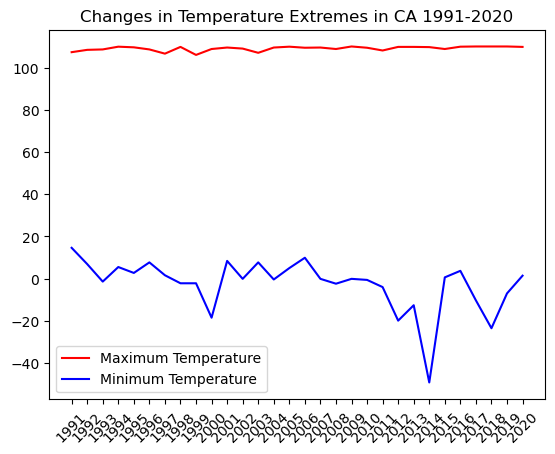

In [12]:
import matplotlib.pyplot as plt

plt.plot(temp_df.year, temp_df.max_temp, c="red", label="Maximum Temperature")
plt.plot(temp_df.year, temp_df.min_temp, c="blue", label="Minimum Temperature")
plt.xticks(ticks=temp_df.year, labels=temp_df.year, rotation=45)
plt.legend()
plt.title("Changes in Temperature Extremes in CA 1991-2020")
plt.show()

## Machine Learning in BigQuery

BigQuery has built-in machine learning methods for quick application to large datasets (6). The following query creates a logistic classification model:

```sql
#standardSQL
CREATE MODEL `bqml_tutorial.sample_model`
OPTIONS(model_type='logistic_reg') AS
SELECT
  IF(totals.transactions IS NULL, 0, 1) AS label,
  IFNULL(device.operatingSystem, "") AS os,
  device.isMobile AS is_mobile,
  IFNULL(geoNetwork.country, "") AS country,
  IFNULL(totals.pageviews, 0) AS pageviews
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170630'
```
**Note**: `bqml_tutorial` refers to the new dataset I created in my project for this example. 

## Model Training Overview

![training output](./assets/gbq-ml-training.png)

## Evaluate Machine Learning Model

In [7]:
evaluate = """
#standardSQL
SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_tutorial.sample_model`, (
SELECT
  IF(totals.transactions IS NULL, 0, 1) AS label,
  IFNULL(device.operatingSystem, "") AS os,
  device.isMobile AS is_mobile,
  IFNULL(geoNetwork.country, "") AS country,
  IFNULL(totals.pageviews, 0) AS pageviews
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20170701' AND '20170801'))
"""

pd.read_gbq(evaluate)

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.468504,0.110801,0.985343,0.179217,0.046242,0.981742


## ML Model Predictions

In [37]:
get_pred = """
SELECT
  country,
  SUM(predicted_label) as total_predicted_purchases
FROM
  ML.PREDICT(MODEL `bqml_tutorial.sample_model`, (
SELECT
  IFNULL(device.operatingSystem, "") AS os,
  device.isMobile AS is_mobile,
  IFNULL(totals.pageviews, 0) AS pageviews,
  IFNULL(geoNetwork.country, "") AS country
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE _TABLE_SUFFIX BETWEEN '20170701' AND '20170801'))
GROUP BY country
ORDER BY total_predicted_purchases DESC
LIMIT 5"""
pd.read_gbq(get_pred)

,country,total_predicted_purchases
0,United States,220
1,Taiwan,8
2,Canada,7
3,Turkey,2
4,India,2


## Comparison to Local - Fitting

In [35]:
%%time
get_training_data = """
SELECT
  IF(totals.transactions IS NULL, 0, 1) AS label,
  IFNULL(device.operatingSystem, "") AS os,
  device.isMobile AS is_mobile,
  IFNULL(geoNetwork.country, "") AS country,
  IFNULL(totals.pageviews, 0) AS pageviews
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170630'
"""

train_data = pd.read_gbq(get_training_data)

CPU times: user 5.05 s, sys: 971 ms, total: 6.03 s
Wall time: 35.2 s


In [41]:
%%time
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

y = train_data.pop('label').to_numpy().astype('int')
enc = OneHotEncoder()
X = enc.fit_transform(train_data)

glm = LogisticRegression(max_iter=500)
glm.fit(X, y)

glm.score(X, y)

CPU times: user 5.21 s, sys: 297 ms, total: 5.51 s
Wall time: 5.55 s


0.9875061046564209

The cloud console query took 3 minutes to fit the model, so it's faster to run locally but the cloud version would scale to larger datasets. Also the cloud version required no overhead or other technical know-how.

**Note:** The BigQuery ML default does not use class weights, even when classes are clearly imbalanced.

## Summary and Recommendation

- BigQuery is a **cloud data warehouse** that stores structured data and can be queried efficiently.
- **Scales horizontally**, so large datasets work just as well as smaller datasets.
- Can connect to multiple data sources and schedule scripts for automated data pipelines.
- Connects to several Google analysis pipelines such as Looker Studio, Colab, and Sheets. 
- BigQuery (and Google Cloud in general) has good community package support for working with APIs programmatically.
- The service is priced by analysis (amount of data scanned by queries) and storage (amount of data kept in BigQuery) (7).


### Recommendation

Google BigQuery is an appealing choice for **customers in the Google Cloud Products ecosystem**. The main competitors are **AWS Redshift** and **Snowflake** (8). Redshift is currently the most popular and Snowflake is the fastest growing. For customers not already using GCP, BigQuery could be a good choice for workflows that will utilize Google's industry-leading **machine learning capabilities**.

## Further Resources 

 - Book: Tigani, Jordan., Naidu, Siddartha. Google BigQuery Analytics. Germany: Wiley, 2014. (Available through UC access to O-Reilly Online)
 - Google overview and pricing: https://cloud.google.com/bigquery  
 - Google Quickstarts: https://cloud.google.com/bigquery/docs/quickstarts
   - Public datasets: https://cloud.google.com/bigquery/docs/quickstarts/query-public-dataset-console
   - Create table: https://cloud.google.com/bigquery/docs/quickstarts/load-data-console
   - BigQuery ML: https://cloud.google.com/bigquery-ml/docs/create-machine-learning-model 
 - `pandas_gbq` documentation: https://pandas-gbq.readthedocs.io/en/latest/index.html
 - BigQuery ML Example by Fireship: https://www.youtube.com/watch?v=ajTp60neMlc 

## References

1. https://cloud.google.com/learn/what-is-a-data-warehouse 
2. Tigani, Jordan., Naidu, Siddartha. Google BigQuery Analytics. Germany: Wiley, 2014.
3. https://cloud.google.com/bigquery 
4. https://pandas-gbq.readthedocs.io/en/latest/index.html
5. https://pandas.pydata.org/docs/reference/api/pandas.read_gbq.html 
6. https://cloud.google.com/bigquery-ml/docs/create-machine-learning-model
7. https://cloud.google.com/bigquery/pricing  
8. https://medium.com/2359media/redshift-vs-bigquery-vs-snowflake-a-comparison-of-the-most-popular-data-warehouse-for-data-driven-cb1c10ac8555 